## Overview

Short term forecasting in the renewable energy sector is becoming increasingly important. With renewables penetrating the market faster than expected, and the inherent uncertainty involved with weather forecasts, it is putting a lot of strain on the existing energy providers and distributors to both manage and balance the power grid. Doing so efficiently requires accurate knowledge of both both supply and demand. As both of these are future events, forecasting is required to predict these factors. Energy demand is a more stable signal than supply of renewable energy which is based on local weather systems relative to the energy generation. Of course demand can also spike unexpectedly with events such as extreme weather spells. Bad predictions can cause energy providers to end up with a shortfall in supply which means they will be required to generate the shortfall by burning more expensive and less climate friendly fuels. It can also result in large oversupply where the company is burning fuel needlessly with is both bad economically and for the climate. Therefore, better predictions in the [1, 48] hour time horizon are absolutely central to efficiently balancing supply and demand in the energy grid. 

In this post, we will show you how to implement a short term weather forecast using a type of deep learning known as recurrent neural networks ([RNN](https://en.wikipedia.org/wiki/Recurrent_neural_network)). The particular type of RNN we use is called a Long Short Term Memory ([LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory)) network. We will use [Keras](https://keras.io/) (version 2+) with the [TensorFlow](https://www.tensorflow.org/) backend as the framework for building this network. 

In this post we're not going to argue the merits of deep learning via LSTMs vs more classical methods such as [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) or vice versa. Instead we're simply showing how to approach and implement a forecasting problem using LSTMs. In general simpler machine learning models should be tried first.


### Why use a Recurrent Neural Network

Recurrent neural networks enable the learning and encoding of temporal features of a signal. This is ideal for forecasting signals which are in some way predictive based on past events. LSTMs are a type of recurrent networks that overcome some of the historic issues related to training recurrent networks, such as the [vanishing gradients problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem). We won't delve into the details of LSTMs here and will instead point you to this [article](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) for a thorough overview. 


### ARIMA

Auto-Regressive Integrated Moving Average ([ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average)) models are the most general and commonly used class of models for forecasting of a stationary signal (or on which can be made stationary). They support random walk, seasonal trend, non-seasonal exponentional smoothing and autoregressive models. 

Lags of the stationarized series in the forecasting equation are called "autoregressive" terms, lags of the forecast errors are called "moving average" terms, and a time series which needs to be differenced to be made stationary is said to be an "integrated" version of a stationary series. Random-walk and random-trend models, autoregressive models, and exponential smoothing models are all special cases of ARIMA models. See [here](https://people.duke.edu/~rnau/411arim.htm) for more details. While there is a relatively systematic approach to determining the ARIMA model parameters. There are many many publications and applications of ARIMA to renewables forecasting with various extensions to solve different issues. 

To see an application of ARIMA for forecasting and the method for determining the model parameters, see the following [notebook](https://datascience.ibm.com/exchange/public/entry/view/815137c868b916821dec777bdc23013c). 


### Baseline Comparison

As a baseline model comparison, we will compare the results of the LSTM predictions with that of a persistence method forecast. A persistence method forecast is simply one that uses the observed reading from the previous timestamp to predict the current timestamp. Such a method is very simple but surprisingly effective in complex systems where values between successive timestamps changes little. However as the forecast horizon increases, these methods can be seen to be less and less effective. However, cyclical patterns can lead to larger horizons being more accurate than medium horizons (think about the presistence method forecast for the temperature at horizon 12 and 24 hours.. The 24 hour prediction should be more accurate than the 12 hour as it is for the same time of day)

In [1]:
%matplotlib inline

import seaborn as sns
sns.set_color_codes()

## Weather Data

As we want to make predictions on the weather at a given location at a given point in time, we need observational data for that location. Another common approach is to predict the power output of a wind farm based which is of course based on the weather and the power conversion properties of the wind turbines. However as the power output prediction relies on the weather prediction and the power conversion properties of the wind turbines, modelling the weather predictions can be seen as the first step in modelling the power output. 

There are many caveats we won’t go into in this post on the observational data such as the height of the observation tower relative to the turbines and other similarly important factors. An ideal scenario would be observations of the weather data from the same location and height of each turbine in a wind farm. This would provide the most accurate observational data to use in training our models. Sometimes it is easier to model the turbin power output as it can be more stable and incorporate the power conversion properties of the tubines also. However, for the purposes of demonstration, we will use the weather observation available from the nearest NOAA weather station which happens to be El Prat Airport in Barcelona. This is from a height of only 8 metres and measurements at this height tend to be more unstable.

It is also highly advisable to include at least one numerical weather models predictions in your model. These models will help predict the effect of global weather patterns and potential impact that can have on the more local scale. Remember, we are not using the global weather data to build our model and so we cannot accurately attempt to predict global weather systems which can naturally move across local areas.


### Observational Data

We get the observational data from NOAA. NOAA collects the weather station observations from stations in countries all around the world. To get it for a given station, you just need to know whats known as the USAF and WBAN IDs. We are using Barcelona El Prat Airport in this notebook but you can change to whatever. 

We providea script that allows you to download the data locally

    data/download-observations.sh
    
We then read and parse this data for the exact weather observation station we wish to work with (there are, or have been multiple in El Prat). Don't use data from many stations as its unlikely to be consistent (same height, location etc). 

Sometimes the stations have readings every 30 minutes and sometimes every hour. We have seen that not all of the meterological readings are available every 30 minutes in such circumstances and so in this example we only use the hourly data. 


In [2]:
import gzip
from io import BytesIO
from ish_parser import ish_parser

def read_observations(years, usaf='081810', wban='99999'):
    parser = ish_parser()
    
    for year in years:
        path = "data/observations/{usaf}-{wban}-{year}.gz".format(year=year, usaf=usaf, wban=wban)
        with gzip.open(path) as gz:
            parser.loads(bytes.decode(gz.read()))
            
    reports = parser.get_reports()
    
    station_latitudes = [41.283, 41.293] 
    observations = pd.DataFrame.from_records(((r.datetime, 
                                               r.air_temperature.get_numeric(),
                                               (r.precipitation[0]['depth'].get_numeric() if r.precipitation else 0),
                                               r.humidity.get_numeric(),
                                               r.sea_level_pressure.get_numeric(),
                                               r.wind_speed.get_numeric(),
                                               r.wind_direction.get_numeric()) 
                                              for r in reports if r.latitude in station_latitudes and r.datetime.minute == 0),
                             columns=['timestamp', 'AT', 'precipitation', 'humidity', 'pressure', 'wind_speed', 'wind_direction'], 
                             index='timestamp')
    
    return observations


### Numerical Weather Models

The numerical weather model (NWM) we're going to use to help us take into account information other than the local station observations is the NEMS4 model. This is provided free of charge to download by [MeteoBlue](https://www.meteoblue.com) for a given date range for a given station. We read and parse this raw download format here.  

Using a weather model is really important as you cannot hope to account for weather systems moving across a local region without it. An important point to note is that the weather model and observations are not meant to match exactly as the model may be predicting for a different height than the observations. However the boundary and ramp events are what we're after. 

TODO: Get this info off Nico

In [3]:
import json
import pandas as pd
import numpy as np

nems4_lookahead=12

def read_nems4(years, prediction_hours=12):
    predictions=pd.DataFrame()
    for year in years:
        with open('data/NEMS4/{}.json'.format(year)) as json_data:
            d = json.load(json_data)
            if not predictions.empty:
                predictions = predictions.append( pd.DataFrame(d['history_1h']))
            else:
                predictions = pd.DataFrame(d['history_1h'])

    predictions = predictions.set_index('time')
    predictions.index.name = 'timestamp'
    
    # shift dataset back 12 hours as its a the value is the prediction for the given timestmap 12 hours previously
    predictions.index = pd.to_datetime(predictions.index) - pd.Timedelta(hours=nems4_lookahead)
    predictions.index.tz = 'UTC'

    predictions = predictions[['temperature', 'precipitation', 
                   'relativehumidity', 'sealevelpressure', 
                   'windspeed']]
    
    predictions = predictions.rename(columns={
        'windspeed': 'nems4_wind_speed', 
        'temperature': 'nems4_AT',
        'precipitation': 'nems4_precipitation',
        'relativehumidity': 'nems4_humidity',
        'sealevelpressure': 'nems4_pressure'})
    
    return predictions


### Join the NWM and Observations
Join the datasets by the timestamps

In [4]:
years = range(2007, 2015)
dataset = pd.merge(read_observations(years), read_nems4(years), left_index=True, right_index=True, how='inner')

original = dataset.copy(deep=True)
dataset.describe()

,AT,precipitation,humidity,pressure,wind_speed,wind_direction,nems4_AT,nems4_precipitation,nems4_humidity,nems4_pressure,nems4_wind_speed
count,69153.000000,69054.000000,69130.000000,52759.000000,69182.000000,67561.000000,69198.000000,69198.000000,69198.000000,69198.000000,69198.000000
mean,16.766853,0.080754,67.704470,1016.462495,4.108177,236.313702,16.277155,0.038027,71.139542,1016.022515,3.486428
std,6.758833,1.098300,14.481048,6.862298,2.106659,107.693595,6.708840,0.285613,16.550182,7.107001,1.969970
min,-3.500000,0.000000,8.000000,980.200000,0.000000,10.000000,-5.840000,0.000000,1.000000,982.000000,0.000000
25%,11.600000,0.000000,59.000000,1012.700000,2.600000,160.000000,11.340000,0.000000,60.000000,1012.000000,2.040000
50%,16.700000,0.000000,69.000000,1016.700000,4.100000,240.000000,16.460000,0.000000,73.000000,1016.000000,3.120000
75%,22.300000,0.000000,78.000000,1020.500000,5.100000,340.000000,21.400000,0.000000,85.000000,1020.000000,4.590000
max,35.300000,75.900000,100.000000,1038.700000,27.800000,360.000000,39.210000,16.000000,100.000000,1039.000000,22.320000


### Transformations - Preprocessing

There are a number of preprocessing steps we must take on this data. We only perform the bare minimum in this notebook as an example of how to work with the data. Much more time and analysis should be spend working with missing datapoints in particular and investigating or trying to detect where the instruments may not be working well (e.g. it is reading zero for a given period). Looking at the dataframe statistics in the cell above provide one with a quick eyeball estimate of outliers which should be filtered - for example, if the wind was 100m/sec at any point it is obviously wrong. 

- Dropping Duplicates

As the name implies, we need to ensure we have only unique timepoints. 

- Imputing Missing Values

As mentioned, this step needs some more love. We apply very simple forward filling in this notebook. 

- Standardize / Stationary Signal

A nice resource for understanding stationarity is [here](https://people.duke.edu/~rnau/411diff.htm). A standardised series is easier to predict. Weather data in particular is non stationary with cyclical trends. Hence, we use first order differencing here to transform the signal from non stationary to stationary. We could spend an entire notebook anlaysing this and showing why etc. Instead we refer you back to the [resource](https://people.duke.edu/~rnau/411diff.htm). 

- Normalize

First order differencing results in an approximately zero mean. Despite some sources, it is better to have the data centered around zero for a neural network than have it scaled between [0,1] for example (especially when using tanh activation function). However, an important reason for apply some scaling is to ensure that certain input features don't dominate the learning (if one feature after standardising had range [-1000,1000] and another [-1,1], then the contribution of the first to the distance will dominate that of the second). See this [article](http://www.faqs.org/faqs/ai-faq/neural-nets/part2/section-16.html) for an interesting discussion on the topic. 

Be careful not to use the MinMaxScaler after standardising the signal via first order differences. If you do, you may notice that the mean is no longer zero. This is exactly what we don't want. Therefore in this notebook we use the sklearn StandardScaler which ensures centering and scaling are applied on each input column (feature). 

- Add Horizon (Prediction) columns

As we are working with first order difference values for the wind speed, our predictions are going to be the differences also at the various time horizons. There are two ways we can achieve this. 

The first way is to predict the difference for each time point up to our max horizon. That is if we have a 3 hour horizon we would predict 3 values for hour [1,2,3] respectively. Then to get the prediction at hour 3 we would get the current real value and add the differences for each hour. A major issue with this approach is that the errors compound. At hour 3 we have included the errors for the predictions at hour 1 and 2 also. Extend that to a larger horizon and it doesn't work well. Additionally, you must predict the value at each time step up to the horizon and if the horizon is large it increases the complexity of the network (number of parameters) needlessly.

The second approach is to simply predict the difference at the horizons. So if we wanted to predict for horizons [1,3] then we only need to predict these two values and the prediction at hour 3 can be obtained by adding the 3 hour difference to the current value. This prevents compounding of errors. However, we are not sure if this approach causes stationarity problems in our predictions. 

In [5]:
from sklearn import preprocessing

pd.options.mode.chained_assignment = None
np.random.seed(1234)

def drop_duplicates(df):
    print("Number of duplicates: {}".format(len(df.index.get_duplicates())))
    return df[~df.index.duplicated(keep='first')]
    
def impute_missing(df):
    # todo test with moving average / mean or something smarter than forward fill
    print("Number of rows with nan: {}".format(np.count_nonzero(df.isnull())))
    df.fillna(method='ffill', inplace=True)
    return df
    
def first_order_difference(data, columns):
    for column in columns:
        data[column+'_d'] = data[column].diff(periods=1)
    
    return data.dropna()

def derive_prediction_columns(data, column, horizons):
    for look_ahead in horizons:
        data['prediction_' + str(look_ahead)] = data[column].diff(periods=look_ahead).shift(-look_ahead)
    
    return data.dropna()

def scale_features(scaler, features):
    scaler.fit(features)
    
    scaled = scaler.transform(features)
    scaled = pd.DataFrame(scaled, columns=features.columns)
    
    return scaled

def inverse_prediction_scale(scaler, predictions, original_columns, column):
    loc = original_columns.get_loc(column)
    
    inverted = np.zeros((len(predictions), len(original_columns)))
    inverted[:,loc] = np.reshape(predictions, (predictions.shape[0],))
    
    inverted = scaler.inverse_transform(inverted)[:,loc]
    
    return inverted

def invert_all_prediction_scaled(scaler, predictions, original_columns, horizons):
    inverted = np.zeros(predictions.shape)
    
    for col_idx, horizon in enumerate(horizons):
        inverted[:,col_idx] = inverse_prediction_scale(
            scaler, predictions[:,col_idx], 
            original_columns,
            "prediction_" + str(horizon))
        
    return inverted

def inverse_prediction_difference(predictions, original):
    return predictions + original

def invert_all_prediction_differences(predictions, original):
    inverted = predictions
    
    for col_idx, horizon in enumerate(horizons):
        inverted[:, col_idx] = inverse_prediction_difference(predictions[:,col_idx], original)
        
    return inverted

In [6]:
dataset = drop_duplicates(dataset)
dataset = impute_missing(dataset)

#select features we're going to use
features = dataset[['wind_speed', 
                    'nems4_wind_speed', 
                    'AT', 
                    'nems4_AT', 
                    'humidity', 
                    'nems4_humidity',
                    'pressure',
                    'nems4_pressure']]

# the time horizons we're going to predict (in hours)
horizons = [1, 6, 12, 24]

features = first_order_difference(features, features.columns)
features = derive_prediction_columns(features, 'wind_speed', horizons)

scaler = preprocessing.StandardScaler()
scaled = scale_features(scaler, features)

scaled.describe()

Number of duplicates: 165
Number of rows with nan: 18293


,wind_speed,nems4_wind_speed,AT,nems4_AT,humidity,nems4_humidity,pressure,nems4_pressure,wind_speed_d,nems4_wind_speed_d,AT_d,nems4_AT_d,humidity_d,nems4_humidity_d,pressure_d,nems4_pressure_d,prediction_1,prediction_6,prediction_12,prediction_24
count,6.900800e+04,6.900800e+04,6.900800e+04,6.900800e+04,6.900800e+04,6.900800e+04,6.900800e+04,6.900800e+04,6.900800e+04,6.900800e+04,6.900800e+04,6.900800e+04,6.900800e+04,6.900800e+04,6.900800e+04,6.900800e+04,6.900800e+04,6.900800e+04,6.900800e+04,6.900800e+04
mean,-3.566717e-16,1.680393e-16,-7.907733e-17,-1.993408e-16,-1.713342e-16,-2.059305e-16,-7.789529e-15,-7.769759e-15,1.574725e-17,2.702838e-18,1.657741e-17,1.009060e-17,-2.728580e-18,-1.660315e-18,5.045298e-18,5.220339e-17,-7.500376e-18,1.762637e-17,6.190787e-18,-2.612744e-17
std,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00
min,-1.949420e+00,-1.772110e+00,-3.004746e+00,-3.301075e+00,-4.121122e+00,-4.236730e+00,-5.140027e+00,-4.790031e+00,-1.446204e+01,-1.503608e+01,-7.894069e+00,-8.703198e+00,-7.437843e+00,-1.231936e+01,-2.509671e+01,-6.993820e+00,-1.446192e+01,-8.394489e+00,-7.188859e+00,-1.000997e+01
25%,-7.155426e-01,-7.349701e-01,-7.537458e-01,-7.361154e-01,-6.006095e-01,-6.726005e-01,-5.346007e-01,-5.654560e-01,-7.195400e-01,-5.167970e-01,-5.705993e-01,-5.307731e-01,-5.188563e-01,-5.279457e-01,-3.583810e-01,4.053942e-05,-7.195453e-01,-6.078183e-01,-6.658027e-01,-5.960653e-01
50%,-3.690200e-03,-1.808121e-01,-1.328511e-02,2.889863e-02,8.968714e-02,1.127162e-01,6.610709e-02,-2.179383e-03,-3.753491e-05,-5.168681e-05,-9.504935e-02,-1.565300e-01,6.767789e-05,2.805332e-05,1.454721e-04,4.053942e-05,-4.900348e-05,-7.816041e-05,-1.847117e-04,-2.486598e-04
75%,4.708781e-01,5.614545e-01,8.160308e-01,7.625963e-01,7.109541e-01,8.376240e-01,5.953020e-01,5.610973e-01,4.316640e-01,4.536759e-01,3.805006e-01,3.743730e-01,5.189917e-01,5.280018e-01,3.586719e-01,4.053942e-05,4.316487e-01,6.076620e-01,6.654333e-01,5.955680e-01
max,1.124358e+01,9.575419e+00,2.741228e+00,3.417031e+00,2.229607e+00,1.743759e+00,3.226974e+00,3.236661e+00,1.928263e+01,1.310763e+01,7.799080e+00,8.642535e+00,7.610953e+00,1.143946e+01,2.671037e+01,8.392674e+00,1.928245e+01,9.571829e+00,8.220198e+00,7.785089e+00


### Creating the Test & Train Datasets for Keras LSTM

In Keras there are two types of LSTM configurations. One is called stateful and the other non stateful. This terminology can be confusing as after all, the very reason for using LSTMs is their temporal memory (i.e. state). This is different to what the term stateful in the LSTM configuration in Keras means.

A stateful Keras LSTM network is one where the internal LSTM units are not reset at all during a training epoc (in fact even between epocs one must manually reset them). This means that the LSTMs build and keep state for the entire training set which means the data must be played through in order. While this is desirable to learn longer term temporal features and dependencies it can be problematic if we have a certain temporal window we want to focus on. 

A non stateful LSTM in Keras terminology resembles more of a classic sliding window approach to training, except where the successive timesteps in the window are framed one after another as a two dimensional array instead of flattened out into a long one dimensional array. This allows the LSTM to learn the state and temporal dependencies between the frames in the time window and Keras will automatically reset the state between each training window. This means that there is no ordering or continuity requirements on the training data outside of the windows.

We cannot reasonably expect the model to pick up very long term dependencies for the weather here given even the most accurate global weather models are chance at horizons of 10 days. Therefore we define our window size (sequence_length) to be 48 hours. You can change to 72 etc to see the difference. The nice things with LSTMs is that you do not increase the number of parameters in the LSTM network by changing this sequence_lenght.

The shape of the X datasets will be a 3D tensor

    (n_samples, sequence_length, n_features)


We are predicting multiple time horizons into the future. Hence we will have multiple network outputs, one for each horizon, which is a 2D tensor

    (n_samples, n_horizons)
    


In [7]:
def prepare_test_train(data, features, predictions, sequence_length, split_percent=0.9):
    
    num_features = len(features)
    num_predictions = len(predictions)
    
     # make sure prediction cols are at end
    columns = features + predictions
    
    data = data[columns].values
    
    print("Using {} features to predict {} horizons".format(num_features, num_predictions))
    
    result = []
    for index in range(len(data) - sequence_length+1):
        result.append(data[index:index + sequence_length])

    result = np.array(result)
    # shape (n_samples, sequence_length, num_features + num_predictions)
    print("Shape of data: {}".format(np.shape(result)))
    
    row = round(split_percent * result.shape[0])
    train = result[:row, :]
    
    X_train = train[:, :, :-num_predictions]
    y_train = train[:, -1, -num_predictions:]
    X_test = result[row:, :, :-num_predictions]
    y_test = result[row:, -1, -num_predictions:]
    
    print("Shape of X train: {}".format(np.shape(X_train)))
    print("Shape of y train: {}".format(np.shape(y_train)))
    print("Shape of X test: {}".format(np.shape(X_test)))
    
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], num_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], num_features))
    
    y_train = np.reshape(y_train, (y_train.shape[0], num_predictions))
    y_test = np.reshape(y_test, (y_test.shape[0], num_predictions))
    
    return X_train, y_train, X_test, y_test, row

In [8]:
sequence_length = 48

prediction_cols = ['prediction_' + str(h) for h in horizons]
feature_cols = ['wind_speed_d', 'nems4_wind_speed_d', 
                'AT_d', 'nems4_AT_d', 
                'humidity_d', 'nems4_humidity_d', 
                'pressure_d', 'nems4_pressure_d']

X_train, y_train, X_test, y_test, row_split = prepare_test_train(
    scaled,
    feature_cols,
    prediction_cols,
    sequence_length,
    split_percent = 0.9)

Using 8 features to predict 4 horizons
Shape of data: (68961, 48, 12)
Shape of X train: (62065, 48, 8)
Shape of y train: (62065, 4)
Shape of X test: (6896, 48, 8)


### Validate Test & Train Dataset Preparation

Ensure we can undo each transformation to get back the original signal. Sanity checks are always good

This is surprisingly tricky when performing first order differencing and the data preprocesssing / structuring required by the LSTM. Ensuring you are adding the correct "original" value is really important. 


In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

#(-1 is because we only take the last y row in each sequence)
sequence_offset = sequence_length  - 1

# validate train
inverse_scale = invert_all_prediction_scaled(scaler, y_train, scaled.columns, horizons)

assert(mean_squared_error(
    features[prediction_cols][sequence_offset:row_split+sequence_offset], 
    inverse_scale) < 1e-10)


undiff_prediction = invert_all_prediction_differences(
    inverse_scale, 
    features['wind_speed'][sequence_offset:row_split+sequence_offset])

for i, horizon in enumerate(horizons):
    assert(mean_squared_error(
        features['wind_speed'][sequence_offset+horizon:row_split+sequence_offset+horizon], 
        undiff_prediction[:,i]) < 1e-10)

    
# validate test
inverse_scale = invert_all_prediction_scaled(scaler, y_test, scaled.columns, horizons)

assert(mean_squared_error(
    features[prediction_cols][sequence_offset+row_split:], 
    inverse_scale) < 1e-10)

undiff_prediction = invert_all_prediction_differences(
    inverse_scale, 
    features['wind_speed'][sequence_offset+row_split:])

for i, horizon in enumerate(horizons):
    assert(mean_squared_error(
        features['wind_speed'][sequence_offset+row_split+horizon:], 
        undiff_prediction[:-horizon,i]) < 1e-10)
    
    

### Build the LSTM Model

Build the non stateful LSTM network. 

We apply regularisation via dropout between each layer in the network. This should help overfitting but we could also add L2 or L2 weight regularization to help also. The RMSProp optimizer is recommended when working with LSTMs. The only tunable property of this is the learning rate. Keras has some callbacks that allow for tuning of this as the training progresses (e.g. see [ReduceLROnPlateau](https://keras.io/callbacks/#reducelronplateau)). 

The first and last layers deserve a comment. The input_shape argument in the first layer specifies the number of input features which is X_train.shape[2]. The last layer is the output layer (hence linear activation) and the size is equal to the number of time horizons we're predicting - y_train.shape[1]. 

We're using a very simple model structure in this notebook with a small number of parameters in each layer. This means we should expect to see trends as opposed to capturing the finer details of the signal. With better and more abundant training data, we could look to use a bigger network with more regularization if necessary to capture higher level and more complext latent features of the signal. 

In [10]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.optimizers import RMSprop

def build_model(layers):
    model = Sequential()
    
    model.add(LSTM(
            layers[1],
            input_shape=(None, layers[0]),
            return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(layers[2], return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(layers[3], return_sequences=False))
    model.add(Dropout(0.2))
    
    model.add(Dense(layers[4], activation="linear"))
    
    model.compile(loss="mse", optimizer='rmsprop')
    
    print(model.summary())
          
    return model

Using TensorFlow backend.


### Train and Evaluate the Model

Fit the model with the training data. We use a validation split of the training data (10%) to allow for things such as early stopping to work (it validates the validation loss against the training loss). 

The size of each network layer is passed in via an argument. The first and last values in that layers array represent the input and output size respectively. The other 3 values represent the size of the 3 layers of the network. 

The batch_size here refers to the number of samples to be taken between gradient updates. Powers of two are recommended and typically values are 256, 512 etc. Batch learning greatly improves the speed of training and the stability of the convergence. 


#### Using AWS or Google Cloud GPUs

While a GPU is absolutely essential to train a large network, for a small network like we are playing with in this notebook you don't gain massively. I found that it was about 8 times faster on a p2.xlarge GPU instance on AWS compared to locally on my 4 core i7. Most of the cloud providers give access to a variety of options for deep learning with optimized instances and GPUs. We won't go into the details of how to do for each or the benefits of one versus the other in this post. We trained the model on a p2.2xlarge instance on AWS using the AWS Spot market which cost approx $0.3 / hour. Training 50 epocs took approximately 20 minutes. 


#### Hyperparameter Tuning

Hyperparameter tuning is an essential part of any machine learning process. Do not fall into the trap of trying to manually hand tune the parameters. There are many formal approaches which optimize this (see my blog [post](http://www.willfleury.com/machine-learning/bayesian-optimization/2017/05/15/hyperparameter-optimisation.html) on the suject). If you are running on Google Cloud Machine Learning it actually has the ability to perform the hyperparameter optimization built into the API. Exactly what type of optimization it performs under the hood is unclear however. 

**NB: As mentioned already in this post, we have not performed an exhaustive training on this model and as such one could easily achieve better results by changing the number of layers, the size of the layers, the sequence_lenght or any one of the other tunable hyperparameters for this model.**



In [11]:
from keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau

def run_network(X_train, y_train, X_test, layers, epochs, batch_size=512):
    model = build_model(layers)
    history = None
    
    try:
        history = model.fit(
            X_train, y_train, 
            batch_size=batch_size, 
            epochs=epochs, 
            validation_split=0.1,
            callbacks=[
                TensorBoard(log_dir='/tmp/tensorboard', write_graph=True),
                #EarlyStopping(monitor='val_loss', patience=5, mode='auto')
            ])
    except KeyboardInterrupt:
        print("\nTraining interrupted")
    
    predicted = model.predict(X_test)
    
    return model, predicted, history


In [29]:
model, predicted, history = run_network(
    X_train, 
    y_train, 
    X_test,
    layers=[X_train.shape[2], 20, 15, 20, y_train.shape[1]],
    epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, None, 20)          2320      
_________________________________________________________________
dropout_16 (Dropout)         (None, None, 20)          0         
_________________________________________________________________
lstm_17 (LSTM)               (None, None, 15)          2160      
_________________________________________________________________
dropout_17 (Dropout)         (None, None, 15)          0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 20)                2880      
_________________________________________________________________
dropout_18 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 84        
Total para

### Visualise Training
Lets plot the training loss vs the valiation loss to get a better idea of whether the network is overfitting, underfitting etc. A good resource for interpreting the results can be found [here](http://cs231n.github.io/neural-networks-3/). 

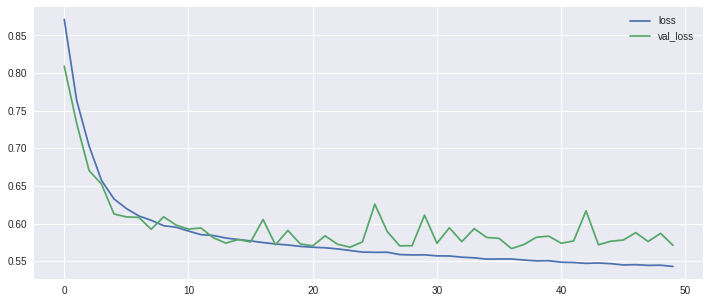

In [30]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

### Validation

Get error scores for the predicted test data. We provide two measures here, [MSE](https://en.wikipedia.org/wiki/Mean_squared_error) to match what the training was and [MAE](https://en.wikipedia.org/wiki/Mean_absolute_error) which can be more relevant for understanding a forecast accuracy. 

We also provide the error scores for each horizon individually. This is very important. We have noticed some articles and worse, libraries, which only provide the **averaged** error score across all the predicted horizons. Naturally, a 1 hour timestep prediction is going to be more accurate than a 24 hour. If we are predicting many horizons then the shorter horizons will be more accurate and reduce the average error score. Therefore its important to evaluate each horizon individually to understand your real predictive power at each step. We can see that the MSE of the test dataset is very similar to the test and validation which is good.

We must also transform the predictions back into actual wind speed values. That means we must unscale and undifference the predictions at the various horizons. We then provide the error scores at these real world scales to again understand the predictions better in a real world context. 


In [126]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("MAE {:.3}, MSE {:.3}".format(
    mean_absolute_error(y_test, predicted),
    mean_squared_error(y_test, predicted)))

for i, horizon in enumerate(horizons):
    print("MAE {:.3f}, MSE {:.3f} for horizon {}".format(
        mean_absolute_error(y_test[:,i], predicted[:,i]),
        mean_squared_error(y_test[:,i], predicted[:,i]),
        horizon))


MAE 0.538, MSE 0.515
MAE 0.622, MSE 0.691 for horizon 1
MAE 0.477, MSE 0.390 for horizon 6
MAE 0.458, MSE 0.354 for horizon 12
MAE 0.595, MSE 0.623 for horizon 24


In [127]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

inverse_scale = invert_all_prediction_scaled(scaler, predicted, scaled.columns, horizons)

predicted_signal = invert_all_prediction_differences(
    inverse_scale, 
    features['wind_speed'][sequence_offset+row_split:])

for i, horizon in enumerate(horizons):
    a = features['wind_speed'][sequence_offset+row_split+horizon:]
    p = predicted_signal[:-horizon,i]
    
    print("Real scale predictions at horizon {:>2} has MAE {:.3f}, MSE {:.3f}, RMSE {:.3f}".format(
        horizon,
        mean_absolute_error(a, p),
        mean_squared_error(a, p),
        sqrt(mean_squared_error(a, p))))


Real scale predictions at horizon  1 has MAE 0.864, MSE 1.335, RMSE 1.156
Real scale predictions at horizon  6 has MAE 1.256, MSE 2.703, RMSE 1.644
Real scale predictions at horizon 12 has MAE 1.377, MSE 3.200, RMSE 1.789
Real scale predictions at horizon 24 has MAE 1.500, MSE 3.953, RMSE 1.988


### Compare Model with Persistence Forecast

As already mentioned, a [persistence forecast](http://ww2010.atmos.uiuc.edu/(Gh)/guides/mtr/fcst/mth/prst.rxml) is a good baseline comparison for any forecasting model. 

We can see that the LSTM model outperforms the persistence method at all horizons. At the 1 hour horizon it is very close as to be expected given such horizons the weather does not change dramatically. At the 6 and 12 hour horizons the LSTM model outperfroms the persistence method by a much larger factor (roughly twice as accurate with an MAE value roughly half that of the persistence method). The 24 hour prediction is only just better than the persistence model which shows the cyclical nature of the wind speed.

With better quality data, and more exhaustive tuning and training of the LSTM network we could resonably expect much better results. 


In [128]:
def evaluate_persistence_forecast(test, horizons):
    for i, horizon in enumerate(horizons):
        a = test[horizon:]
        p = test[:-horizon]
  
        print("Persistence Method prediction at horizon {:>2} has MAE {:.3f}, MSE {:.3f}, RMSE {:.3f}".format(
            horizon,
            mean_absolute_error(a, p),
            mean_squared_error(a, p),
            sqrt(mean_squared_error(a, p))))


evaluate_persistence_forecast(
    features['wind_speed'][sequence_offset+row_split:].values, # ensure we have same test set 
    horizons)

Persistence Method prediction at horizon  1 has MAE 0.950, MSE 1.695, RMSE 1.302
Persistence Method prediction at horizon  6 has MAE 2.008, MSE 6.574, RMSE 2.564
Persistence Method prediction at horizon 12 has MAE 2.319, MSE 8.692, RMSE 2.948
Persistence Method prediction at horizon 24 has MAE 1.861, MSE 6.116, RMSE 2.473


### Visualising 

Finally, we should visualise the predicted wind speeds. We will draw a plot for each time horizon independently. 

We can see from the plots that the predictions follow the signal trends quite well. As the signal is very unstable (lots of minor and major adjustments), we can only expect the short term horizon to match it well, as the adjustment to current is minor (remember we're predicting differences). The further out the horizon the less accurate it is in terms of following the exact jagged edges of the original signal which is expected as modelling such a jagged and unstable signal exactly is extermely difficult (if possible due to bad observations). However, as mentioned it is the general trend and strenght that is important and we can see it performs quite well. With better observational data from a more stable source (and height), this apparent discrepancies would start to dissapear and the signal would have a much lower MAE. In particular the power output of turbines would be much smoother than this and hence fit much nicer.


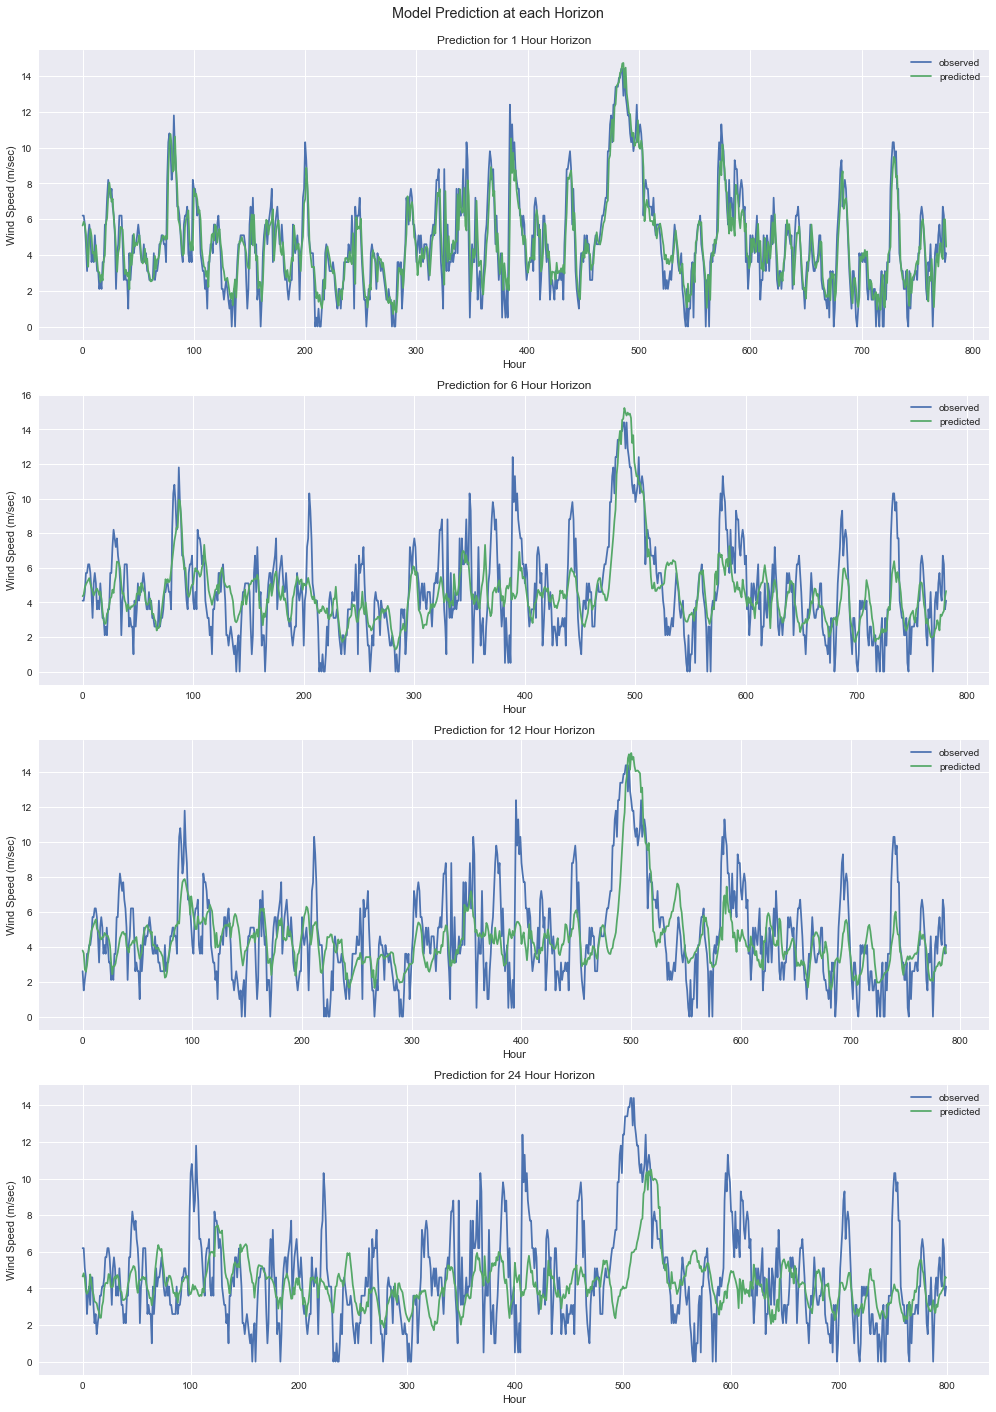

In [165]:
import matplotlib.pyplot as plt

plot_samples=800
tail_trim = 100
plots = len(horizons)

fig = plt.figure(figsize=(14, 5 * plots))
fig.suptitle("Model Prediction at each Horizon")

for i, horizon in enumerate(horizons):
    plt.subplot(plots,1,i+1)
    
    real = features['wind_speed'][sequence_offset+row_split+horizon+(24-horizon):].values
    pred = predicted_signal[(24-horizon):-horizon,i]
    
    plt.plot(real[(24-horizon):plot_samples], label='observed')
    plt.plot(pred[(24-horizon):plot_samples], label='predicted')
    plt.title("Prediction for {} Hour Horizon".format(horizon))
    plt.xlabel("Hour")
    plt.ylabel("Wind Speed (m/sec)")
    plt.legend()
    plt.tight_layout()
    
fig.tight_layout()
plt.subplots_adjust(top=0.95)


### Critique 

One very important property we are missing for our predictions, is the confidence our model has in a given prediction - aka credible interval. We can actually extend this model and add a Mixture Density Network ([MDN](http://edwardlib.org/tutorials/mixture-density-network)) as the final layer in the network. MDNs are very useful when combined with neural networks, where the outputs of the neural network are the parameters of the mixture model, rather than direct prediction of the data label. So for each input, you would have a set of mean parameters, a set of standard deviation parameters, and a set of probabilities that the output point would fall into those gaussian distributions ([taken from](http://blog.otoro.net/2015/06/14/mixture-density-networks/)). In a follow up post we will extend our model with an MDN.

Another critique is that we don't do any feature engineering at all. While one of the stated benefits of deep learning in general is its inherent ability to extract latent features, it would be beneficial at least to test out some standard forecasting features such as trend strenghts etc. They may or may not improve the result. Another interesting idea which Uber recently published about their use of LSTMs for forecasting was to use a separate LSTM autoencoder network to create additional features as input to the LSTM model for prediction. See their article [here](https://eng.uber.com/neural-networks/). This is very easy to achieve with Keras. 